Test raw map point, line and polygon data retrieval

In [ ]:
import pytest
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import carla

import carlautil

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000
DELTA = 0.1

In [18]:
COLOR_BUTTER_0 = np.array([252, 233, 79]) / 255.
COLOR_BUTTER_1 = np.array([237, 212, 0]) / 255.
COLOR_BUTTER_2 = np.array([196, 160, 0]) / 255.

COLOR_ORANGE_0 = np.array([252, 175, 62]) / 255.
COLOR_ORANGE_1 = np.array([245, 121, 0]) / 255.
COLOR_ORANGE_2 = np.array([209, 92, 0]) / 255.

COLOR_CHOCOLATE_0 = np.array([233, 185, 110]) / 255.
COLOR_CHOCOLATE_1 = np.array([193, 125, 17]) / 255.
COLOR_CHOCOLATE_2 = np.array([143, 89, 2]) / 255.

COLOR_CHAMELEON_0 = np.array([138, 226, 52]) / 255.
COLOR_CHAMELEON_1 = np.array([115, 210, 22]) / 255.
COLOR_CHAMELEON_2 = np.array([78, 154, 6]) / 255.

COLOR_SKY_BLUE_0 = np.array([114, 159, 207]) / 255.
COLOR_SKY_BLUE_1 = np.array([52, 101, 164]) / 255.
COLOR_SKY_BLUE_2 = np.array([32, 74, 135]) / 255.

COLOR_PLUM_0 = np.array([173, 127, 168]) / 255.
COLOR_PLUM_1 = np.array([117, 80, 123]) / 255.
COLOR_PLUM_2 = np.array([92, 53, 102]) / 255.

COLOR_SCARLET_RED_0 = np.array([239, 41, 41]) / 255.
COLOR_SCARLET_RED_1 = np.array([204, 0, 0]) / 255.
COLOR_SCARLET_RED_2 = np.array([164, 0, 0]) / 255.

COLOR_ALUMINIUM_0 = np.array([238, 238, 236]) / 255.
COLOR_ALUMINIUM_1 = np.array([211, 215, 207]) / 255.
COLOR_ALUMINIUM_2 = np.array([186, 189, 182]) / 255.
COLOR_ALUMINIUM_3 = np.array([136, 138, 133]) / 255.
COLOR_ALUMINIUM_4 = np.array([85, 87, 83]) / 255.
COLOR_ALUMINIUM_4_5 = np.array([66, 62, 64]) / 255.
COLOR_ALUMINIUM_5 = np.array([46, 52, 54]) / 255.

COLOR_WHITE = np.array([255, 255, 255]) / 255.
COLOR_BLACK = np.array([0, 0, 0]) / 255.

PARKING_COLOR = COLOR_ALUMINIUM_4_5
SHOULDER_COLOR = COLOR_ALUMINIUM_5
SIDEWALK_COLOR = COLOR_ALUMINIUM_3

In [4]:
client = carla.Client(CARLA_HOST, CARLA_PORT)
client.set_timeout(10.0)
world = client.get_world()
carla_map = world.get_map()
traffic_manager = client.get_trafficmanager(8000)
carla_topology = carla_map.get_topology()

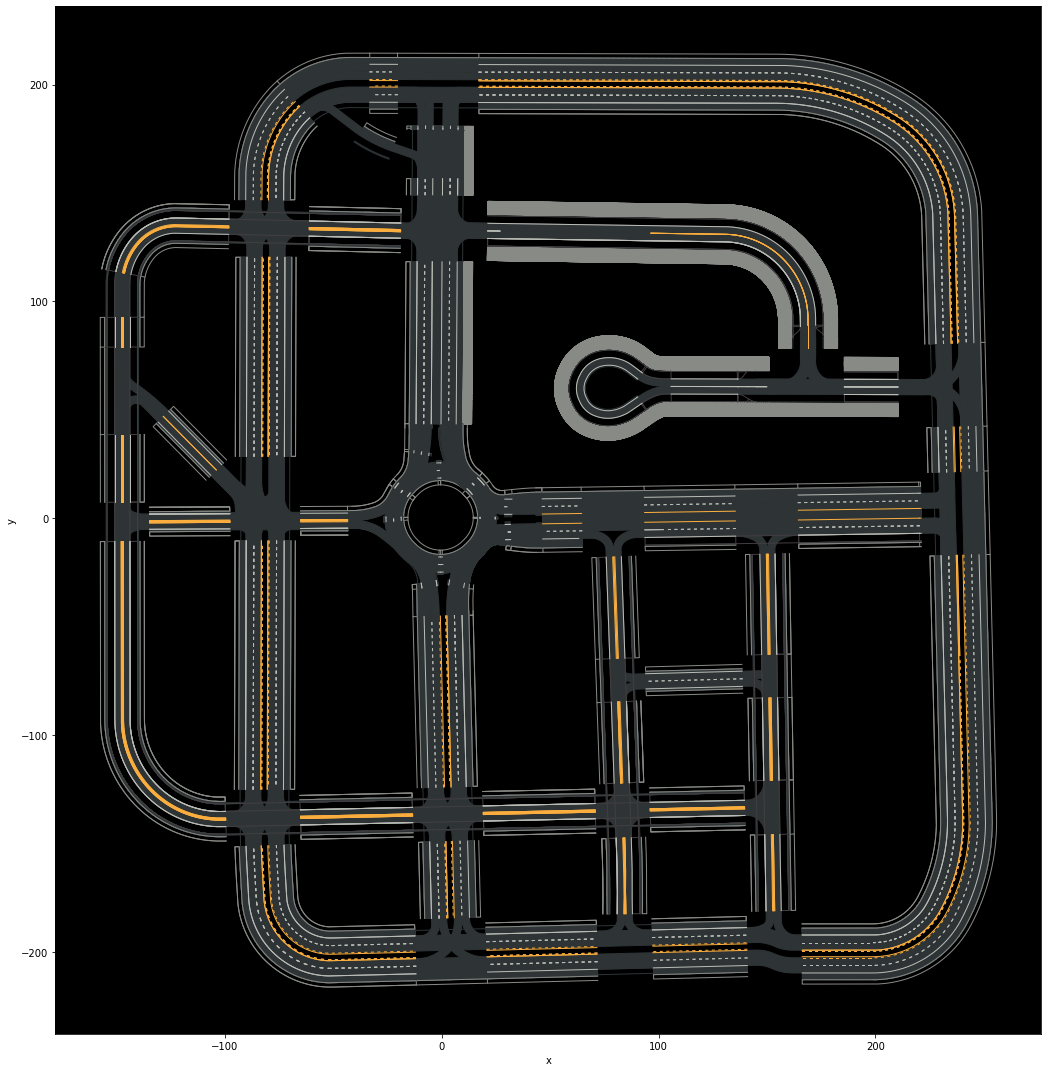

In [32]:
fig, ax = plt.subplots(figsize=(15,15))

"""
# Converts the world coordinates to pixel coordinates
def world_to_pixel(self, location, offset=(0, 0)):
    x = self.scale * self._pixels_per_meter * (location.x - self._world_offset[0])
    y = self.scale * self._pixels_per_meter * (location.y - self._world_offset[1])
    return [int(x - offset[0]), int(y - offset[1])]
"""

def draw_solid_line(color, closed, points, width):
    """Draws solid lines in a surface given a set of points, width and color"""
    if len(points) >= 2:
        ax.plot(points.T[0], points.T[1], c=color, linewidth=1)
        # pygame.draw.lines(surface, color, closed, points, width)

def draw_broken_line(color, closed, points, width):
    """Draws broken lines in a surface given a set of points, width and color"""
    # Select which lines are going to be rendered from the set of lines
    broken_lines = np.array([x for n, x in enumerate(zip(*(iter(points),) * 20)) if n % 3 == 0])

    # Draw selected lines
    for line in broken_lines:
        ax.plot(line.T[0], line.T[1], c=color, linewidth=1)
        # pygame.draw.lines(surface, color, closed, line, width)

def lane_marking_color_to_tango(lane_marking_color):
    """Maps the lane marking color enum specified in PythonAPI to a Tango Color"""
    tango_color = COLOR_BLACK

    if lane_marking_color == carla.LaneMarkingColor.White:
        tango_color = COLOR_ALUMINIUM_2

    elif lane_marking_color == carla.LaneMarkingColor.Blue:
        tango_color = COLOR_SKY_BLUE_0

    elif lane_marking_color == carla.LaneMarkingColor.Green:
        tango_color = COLOR_CHAMELEON_0

    elif lane_marking_color == carla.LaneMarkingColor.Red:
        tango_color = COLOR_SCARLET_RED_0

    elif lane_marking_color == carla.LaneMarkingColor.Yellow:
        tango_color = COLOR_ORANGE_0

    return tango_color

def get_lane_markings(lane_marking_type, lane_marking_color, waypoints, sign):
    """For multiple lane marking types (SolidSolid, BrokenSolid, SolidBroken and BrokenBroken), it converts them
     as a combination of Broken and Solid lines"""
    margin = 0.25
    # marking_1 = [world_to_pixel(lateral_shift(w.transform, sign * w.lane_width * 0.5)) for w in waypoints]
    marking_1 = [lateral_shift(w.transform, sign * w.lane_width * 0.5) for w in waypoints]
    marking_1 = carlautil.locations_to_ndarray(marking_1)
    
    if lane_marking_type == carla.LaneMarkingType.Broken or (lane_marking_type == carla.LaneMarkingType.Solid):
        return [(lane_marking_type, lane_marking_color, marking_1)]
    else:
        
        # marking_2 = [world_to_pixel(lateral_shift(w.transform,
        #         sign * (w.lane_width * 0.5 + margin * 2))) for w in waypoints]
        marking_2 = [lateral_shift(w.transform,
                sign * (w.lane_width * 0.5 + margin * 2)) for w in waypoints]
        marking_2 = carlautil.locations_to_ndarray(marking_2)
        
        if lane_marking_type == carla.LaneMarkingType.SolidBroken:
            return [(carla.LaneMarkingType.Broken, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Solid, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.BrokenSolid:
            return [(carla.LaneMarkingType.Solid, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Broken, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.BrokenBroken:
            return [(carla.LaneMarkingType.Broken, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Broken, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.SolidSolid:
            return [(carla.LaneMarkingType.Solid, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Solid, lane_marking_color, marking_2)]

    return [(carla.LaneMarkingType.NONE, carla.LaneMarkingColor.Other, [])]

def draw_lane_marking_single_side(waypoints, sign):
    """Draws the lane marking given a set of waypoints and decides whether drawing the right or left side of
    the waypoint based on the sign parameter"""
    lane_marking = None

    marking_type = carla.LaneMarkingType.NONE
    previous_marking_type = carla.LaneMarkingType.NONE

    marking_color = carla.LaneMarkingColor.Other
    previous_marking_color = carla.LaneMarkingColor.Other

    markings_list = []
    temp_waypoints = []
    current_lane_marking = carla.LaneMarkingType.NONE
    for sample in waypoints:
        lane_marking = sample.left_lane_marking if sign < 0 else sample.right_lane_marking

        if lane_marking is None:
            continue

        marking_type = lane_marking.type
        marking_color = lane_marking.color

        if current_lane_marking != marking_type:
            # Get the list of lane markings to draw
            markings = get_lane_markings(
                previous_marking_type,
                lane_marking_color_to_tango(previous_marking_color),
                temp_waypoints,
                sign)
            current_lane_marking = marking_type

            # Append each lane marking in the list
            for marking in markings:
                markings_list.append(marking)

            temp_waypoints = temp_waypoints[-1:]

        else:
            temp_waypoints.append((sample))
            previous_marking_type = marking_type
            previous_marking_color = marking_color

    # Add last marking
    last_markings = get_lane_markings(
        previous_marking_type,
        lane_marking_color_to_tango(previous_marking_color),
        temp_waypoints,
        sign)
    for marking in last_markings:
        markings_list.append(marking)

    # Once the lane markings have been simplified to Solid or Broken lines, we draw them
    for markings in markings_list:
        if markings[0] == carla.LaneMarkingType.Solid:
            draw_solid_line(markings[1], False, markings[2], 2)
        elif markings[0] == carla.LaneMarkingType.Broken:
            draw_broken_line(markings[1], False, markings[2], 2)

def draw_lane_marking(waypoints):
    """Draws the left and right side of lane markings"""
    # Left Side
    draw_lane_marking_single_side(waypoints[0], -1)

    # Right Side
    draw_lane_marking_single_side(waypoints[1], 1)

def lateral_shift(transform, shift):
    """Makes a lateral shift of the forward vector of a transform"""
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

def draw_lane(lane, color):
    """Renders a single lane in a surface and with a specified color"""
    for side in lane:
        lane_left_side  = [lateral_shift(w.transform, -w.lane_width * 0.5) for w in side]
        lane_right_side = [lateral_shift(w.transform,  w.lane_width * 0.5) for w in side]

        # get rid of pygame
        # polygon : list of carla.Vector3D
        polygon = lane_left_side + [x for x in reversed(lane_right_side)]
        polygon = carlautil.locations_to_ndarray(polygon)

        if len(polygon) > 2:
            ax.plot(polygon.T[0], polygon.T[1], c=color, linewidth=1)

precision = 0.05
index = 0
topology = [x[index] for x in carla_topology]
topology = sorted(topology, key=lambda w: w.transform.location.z)
set_waypoints = []
for waypoint in topology:
    waypoints = [waypoint]
    nxt = waypoint.next(precision)
    if len(nxt) > 0:
        nxt = nxt[0]
        while nxt.road_id == waypoint.road_id:
            waypoints.append(nxt)
            nxt = nxt.next(precision)
            if len(nxt) > 0:
                nxt = nxt[0]
            else:
                break
    set_waypoints.append(waypoints)
    shoulder = [[], []]
    parking = [[], []]
    sidewalk = [[], []]
    
    for w in waypoints:
        # Classify lane types until there are no waypoints by going left
        l = w.get_left_lane()
        while l and l.lane_type != carla.LaneType.Driving:

            if l.lane_type == carla.LaneType.Shoulder:
                shoulder[0].append(l)

            if l.lane_type == carla.LaneType.Parking:
                parking[0].append(l)

            if l.lane_type == carla.LaneType.Sidewalk:
                sidewalk[0].append(l)

            l = l.get_left_lane()

        # Classify lane types until there are no waypoints by going right
        r = w.get_right_lane()
        while r and r.lane_type != carla.LaneType.Driving:

            if r.lane_type == carla.LaneType.Shoulder:
                shoulder[1].append(r)

            if r.lane_type == carla.LaneType.Parking:
                parking[1].append(r)

            if r.lane_type == carla.LaneType.Sidewalk:
                sidewalk[1].append(r)

            r = r.get_right_lane()
        
    # Draw classified lane types
    draw_lane(shoulder, SHOULDER_COLOR)
    draw_lane(parking, PARKING_COLOR)
    draw_lane(sidewalk, SIDEWALK_COLOR)
    
# Draw Roads
for waypoints in set_waypoints:
    waypoint = waypoints[0]
    road_left_side  = [lateral_shift(w.transform, -w.lane_width * 0.5) for w in waypoints]
    road_right_side = [lateral_shift(w.transform,  w.lane_width * 0.5) for w in waypoints]
    polygon = road_left_side + [x for x in reversed(road_right_side)]
    polygon = carlautil.locations_to_ndarray(polygon)
    if len(polygon) > 2:
        # Uncomment to draw as wire frame
#         ax.plot(polygon.T[0], polygon.T[1], c='red', linewidth=1)
        
        patch = matplotlib.patches.Polygon(polygon[:,:2], fill=True, color=COLOR_ALUMINIUM_5)
        ax.add_patch(patch)
        
    if not waypoint.is_junction:
        draw_lane_marking([waypoints, waypoints])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

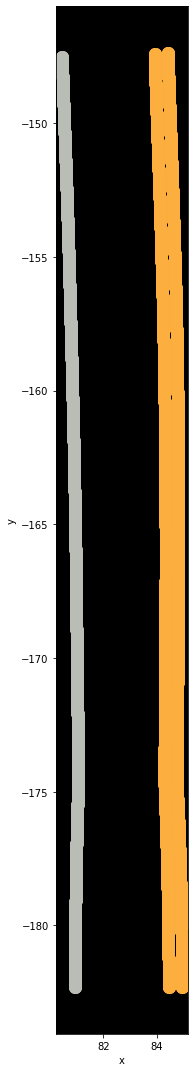

In [36]:
fig, ax = plt.subplots(figsize=(15,15))

"""
# Converts the world coordinates to pixel coordinates
def world_to_pixel(self, location, offset=(0, 0)):
    x = self.scale * self._pixels_per_meter * (location.x - self._world_offset[0])
    y = self.scale * self._pixels_per_meter * (location.y - self._world_offset[1])
    return [int(x - offset[0]), int(y - offset[1])]
"""

def draw_solid_line(color, closed, points, width):
    """Draws solid lines in a surface given a set of points, width and color"""
    if len(points) >= 2:
        ax.plot(points.T[0], points.T[1], c=color, linewidth=1, marker='o', markersize=12)
        # pygame.draw.lines(surface, color, closed, points, width)

def draw_broken_line(color, closed, points, width):
    """Draws broken lines in a surface given a set of points, width and color"""
    # Select which lines are going to be rendered from the set of lines
    broken_lines = np.array([x for n, x in enumerate(zip(*(iter(points),) * 20)) if n % 3 == 0])

    # Draw selected lines
    for line in broken_lines:
        ax.plot(line.T[0], line.T[1], c=color, linewidth=1, marker='o', markersize=12)
        # pygame.draw.lines(surface, color, closed, line, width)

def lane_marking_color_to_tango(lane_marking_color):
    """Maps the lane marking color enum specified in PythonAPI to a Tango Color"""
    tango_color = COLOR_BLACK

    if lane_marking_color == carla.LaneMarkingColor.White:
        tango_color = COLOR_ALUMINIUM_2

    elif lane_marking_color == carla.LaneMarkingColor.Blue:
        tango_color = COLOR_SKY_BLUE_0

    elif lane_marking_color == carla.LaneMarkingColor.Green:
        tango_color = COLOR_CHAMELEON_0

    elif lane_marking_color == carla.LaneMarkingColor.Red:
        tango_color = COLOR_SCARLET_RED_0

    elif lane_marking_color == carla.LaneMarkingColor.Yellow:
        tango_color = COLOR_ORANGE_0

    return tango_color

def get_lane_markings(lane_marking_type, lane_marking_color, waypoints, sign):
    """For multiple lane marking types (SolidSolid, BrokenSolid, SolidBroken and BrokenBroken), it converts them
     as a combination of Broken and Solid lines"""
    margin = 0.25
    # marking_1 = [world_to_pixel(lateral_shift(w.transform, sign * w.lane_width * 0.5)) for w in waypoints]
    marking_1 = [lateral_shift(w.transform, sign * w.lane_width * 0.5) for w in waypoints]
    marking_1 = carlautil.locations_to_ndarray(marking_1)
    
    if lane_marking_type == carla.LaneMarkingType.Broken or (lane_marking_type == carla.LaneMarkingType.Solid):
        return [(lane_marking_type, lane_marking_color, marking_1)]
    else:
        
        # marking_2 = [world_to_pixel(lateral_shift(w.transform,
        #         sign * (w.lane_width * 0.5 + margin * 2))) for w in waypoints]
        marking_2 = [lateral_shift(w.transform,
                sign * (w.lane_width * 0.5 + margin * 2)) for w in waypoints]
        marking_2 = carlautil.locations_to_ndarray(marking_2)
        
        if lane_marking_type == carla.LaneMarkingType.SolidBroken:
            return [(carla.LaneMarkingType.Broken, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Solid, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.BrokenSolid:
            return [(carla.LaneMarkingType.Solid, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Broken, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.BrokenBroken:
            return [(carla.LaneMarkingType.Broken, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Broken, lane_marking_color, marking_2)]
        elif lane_marking_type == carla.LaneMarkingType.SolidSolid:
            return [(carla.LaneMarkingType.Solid, lane_marking_color, marking_1),
                    (carla.LaneMarkingType.Solid, lane_marking_color, marking_2)]

    return [(carla.LaneMarkingType.NONE, carla.LaneMarkingColor.Other, [])]

def draw_lane_marking_single_side(waypoints, sign):
    """Draws the lane marking given a set of waypoints and decides whether drawing the right or left side of
    the waypoint based on the sign parameter"""
    lane_marking = None

    marking_type = carla.LaneMarkingType.NONE
    previous_marking_type = carla.LaneMarkingType.NONE

    marking_color = carla.LaneMarkingColor.Other
    previous_marking_color = carla.LaneMarkingColor.Other

    markings_list = []
    temp_waypoints = []
    current_lane_marking = carla.LaneMarkingType.NONE
    for sample in waypoints:
        lane_marking = sample.left_lane_marking if sign < 0 else sample.right_lane_marking

        if lane_marking is None:
            continue

        marking_type = lane_marking.type
        marking_color = lane_marking.color

        if current_lane_marking != marking_type:
            # Get the list of lane markings to draw
            markings = get_lane_markings(
                previous_marking_type,
                lane_marking_color_to_tango(previous_marking_color),
                temp_waypoints,
                sign)
            current_lane_marking = marking_type

            # Append each lane marking in the list
            for marking in markings:
                markings_list.append(marking)

            temp_waypoints = temp_waypoints[-1:]

        else:
            temp_waypoints.append((sample))
            previous_marking_type = marking_type
            previous_marking_color = marking_color

    # Add last marking
    last_markings = get_lane_markings(
        previous_marking_type,
        lane_marking_color_to_tango(previous_marking_color),
        temp_waypoints,
        sign)
    for marking in last_markings:
        markings_list.append(marking)

    # Once the lane markings have been simplified to Solid or Broken lines, we draw them
    for markings in markings_list:
        if markings[0] == carla.LaneMarkingType.Solid:
            draw_solid_line(markings[1], False, markings[2], 2)
        elif markings[0] == carla.LaneMarkingType.Broken:
            draw_broken_line(markings[1], False, markings[2], 2)

def draw_lane_marking(waypoints):
    """Draws the left and right side of lane markings"""
    # Left Side
    draw_lane_marking_single_side(waypoints[0], -1)

    # Right Side
    draw_lane_marking_single_side(waypoints[1], 1)

def lateral_shift(transform, shift):
    """Makes a lateral shift of the forward vector of a transform"""
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

precision = 0.05
index = 0
topology = [x[index] for x in carla_topology]
topology = sorted(topology, key=lambda w: w.transform.location.z)
set_waypoints = []
for waypoint in topology:
    waypoints = [waypoint]
    nxt = waypoint.next(precision)
    if len(nxt) > 0:
        nxt = nxt[0]
        while nxt.road_id == waypoint.road_id:
            waypoints.append(nxt)
            nxt = nxt.next(precision)
            if len(nxt) > 0:
                nxt = nxt[0]
            else:
                break
    set_waypoints.append(waypoints)
    
# Draw Roads
for waypoints in set_waypoints[:5]:
    waypoint = waypoints[0]
    if not waypoint.is_junction:
        draw_lane_marking([waypoints, waypoints])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

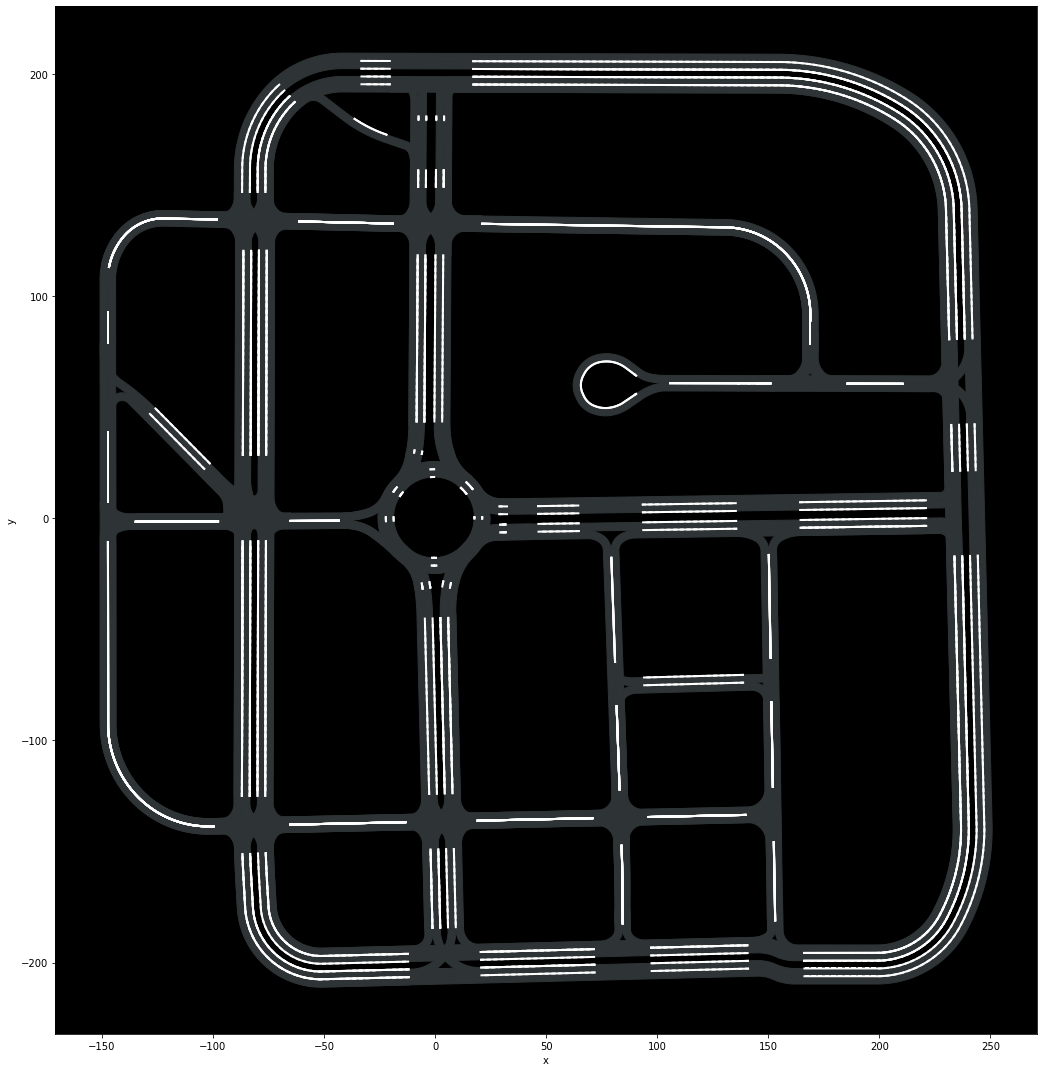

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
precision = 0.05

def draw_lane_marking(points, solid=True):
    if solid:
        ax.plot(points.T[0], points.T[1], c=COLOR_WHITE, linewidth=2)
        # pygame.draw.lines(surface, COLOR_WHITE, False, points, 2)
    else:
        broken_lines = np.array(
                [x for n, x in enumerate(zip(*(iter(points),) * 20)) if n % 3 == 0])
        for line in broken_lines:
            ax.plot(line.T[0], line.T[1], c=COLOR_WHITE, linewidth=2)
            # pygame.draw.lines(surface, COLOR_WHITE, False, line, 2)

def lateral_shift(transform, shift):
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

def does_cross_solid_line(waypoint, shift):
    w = carla_map.get_waypoint(lateral_shift(waypoint.transform, shift), project_to_road=False)
    if w is None or w.road_id != waypoint.road_id:
        return True
    else:
        return (w.lane_id * waypoint.lane_id < 0) or w.lane_id == waypoint.lane_id

topology = [x[0] for x in carla_map.get_topology()]
topology = sorted(topology, key=lambda w: w.transform.location.z)

for waypoint in topology:
    waypoints = [waypoint]
    nxt = waypoint.next(precision)[0]
    while nxt.road_id == waypoint.road_id:
        waypoints.append(nxt)
        nxt = nxt.next(precision)[0]

    left_marking  = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, -w.lane_width * 0.5) for w in waypoints])
    right_marking = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, w.lane_width * 0.5) for w in waypoints])

#     polygon = left_ left_marking + [x for x in reversed(right_marking)]
    polygon = np.concatenate((left_marking, np.flipud(right_marking)), axis=0)
#     polygon = carlautil.locations_to_ndarray(polygon)

    if len(polygon) > 2:
        patch = matplotlib.patches.Polygon(polygon[:,:2], fill=True, color=COLOR_ALUMINIUM_5)
        ax.add_patch(patch)
#         pygame.draw.polygon(map_surface, COLOR_WHITE, polygon, 10)
#         pygame.draw.polygon(map_surface, COLOR_WHITE, polygon)

    if not waypoint.is_intersection:
        sample = waypoints[int(len(waypoints) / 2)]
        draw_lane_marking(
            left_marking,
            # [world_to_pixel(x) for x in left_marking],
            does_cross_solid_line(sample, -sample.lane_width * 1.1))
        draw_lane_marking(
            left_marking,
            # [world_to_pixel(x) for x in right_marking],
            does_cross_solid_line(sample, sample.lane_width * 1.1))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()